https://www.youtube.com/watch?v=iXX4Y0z6KNU

In [21]:
from huggingface_hub import login

login(token="")

In [19]:
# note the image is not provided in the prompt its included as part of the "processor"
prompt= """Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

##PRODUCT NAME##: {product_name}
##CATEGORY##: {category}"""


In [7]:
from datasets import load_dataset

# Load dataset from the hub
dataset_id = "philschmid/amazon-product-descriptions-vlm"
dataset = load_dataset("philschmid/amazon-product-descriptions-vlm", split="train")

dataset 

Dataset({
    features: ['image', 'Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Variants', 'Product Url', 'Is Amazon Seller', 'description'],
    num_rows: 1345
})

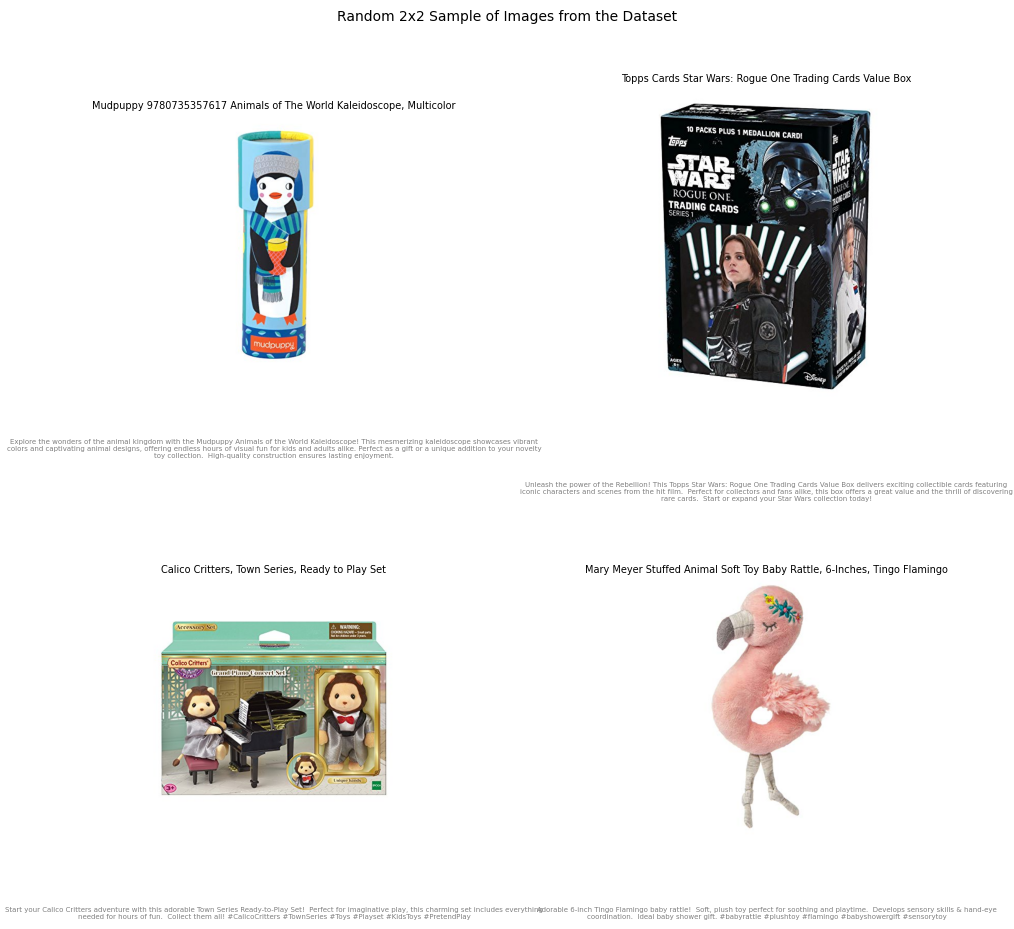

In [18]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Randomly sample 4 rows from the dataset
sampled_indices = random.sample(range(len(dataset)), 4)
sampled_data = [dataset[i] for i in sampled_indices]

# Create a 2x2 grid to display the images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Random 2x2 Sample of Images from the Dataset", fontsize=10)

# Display each image with product name and description
for idx, ax in enumerate(axes.flatten()):
    image_data = sampled_data[idx]['image']  # Access image field
    product_name = sampled_data[idx]['Product Name']  # Product name (title)
    description = sampled_data[idx]['description']  # Description (small text)

    # Convert image to PIL format if needed
    if isinstance(image_data, Image.Image):
        image = image_data
    else:
        image = image_data.convert("RGB")

    # Display the image
    ax.imshow(image)
    ax.set_title(f"{product_name}", fontsize=7)  # Product name as title
    ax.axis("off")
    
    # Add description below the image in smaller text
    ax.text(
        0.5, -0.3, description, 
        fontsize=5, color="gray", ha="center", va="center", 
        transform=ax.transAxes, wrap=True
    )

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.5)  # Add spacing
plt.show()


In [3]:

# Convert dataset to OAI messages
def format_data(sample):
    return {"messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt.format(product_name=sample["Product Name"], category=sample["Category"]),
                        },{
                            "type": "image",
                            "image": sample["image"],
                        }
                    ],
                },
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": sample["description"]}],
                },
            ],
        }


# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .mape convert image to bytes
dataset = [format_data(sample) for sample in dataset]

print(dataset[345]["messages"])

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1345 [00:00<?, ? examples/s]

[{'role': 'user', 'content': [{'type': 'text', 'text': 'Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n##PRODUCT NAME##: MasterPieces Tribal Spirit Jigsaw Puzzle, The Chiefs, Featuring American Indian Tribe Traditions & Ceremonies, 1000 Pieces\n##CATEGORY##: Toys & Games | Puzzles | Jigsaw Puzzles'}, {'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F7F783DEBC0>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Challenge yourself with this 1000-piece MasterPieces Tribal Spirit jigsaw puzzle!  Depicting the rich traditions and ceremonies of American Indian tribes, "The Chiefs" offers a stunning, culturally significant image perfect for puzzle enthusiasts.  High-quality pieces guarantee a satisfying solve.'}]}]


In [4]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

# Hugging Face model id
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2", # not supported for training
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

In [5]:
text = processor.apply_chat_template(
    dataset[2]["messages"], tokenize=False, add_generation_prompt=False
)
text

'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nCreate a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n##PRODUCT NAME##: Barbie Fashionistas Doll Wear Your Heart\n##CATEGORY##: Toys & Games | Dolls & Accessories | Dolls<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nExpress your style with Barbie Fashionistas Doll Wear Your Heart! This fashionable doll boasts a unique outfit and accessories, perfect for imaginative play.  A great gift for kids aged 3+.  Collect them all! #Barbie #Fashionistas #Doll #Toys #GirlsToys #FashionDoll #Play<|eot_id|>'

In [22]:
from peft import LoraConfig

# LoRA config based on QLoRA paper & Sebastian Raschka experiment
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=8,
        bias="none",
        target_modules=["q_proj", "v_proj"],
        task_type="CAUSAL_LM",
)


In [23]:
from trl import SFTConfig


args = SFTConfig(
    output_dir="fine-tuned-visionllama", # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_accumulation_steps=8,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)
args.remove_unused_columns=False

In [26]:
from transformers import Qwen2VLProcessor


def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example["messages"], tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example["messages"])[0] for example in examples]

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  #
    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):
        image_tokens = [151652,151653,151655]
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

In [27]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    data_collator=collate_fn,
    dataset_text_field="", # needs dummy value
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


In [28]:
trainer.train()

KeyError: 'messages'